**<h1>IMPORT LIBRARIES</h1>**

In [1]:
import os
import re
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, GRU, Dense, LayerNormalization
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

**<h1>READ DATASET</h1>**

In [ ]:
data = pd.read_csv('./resetted_index_cleaned_polarity_roberta.csv', index_col=0)

In [ ]:
pos = data[data['sentiment'] == 'positive'].head(312564)
neu = data[data['sentiment'] == 'neutral'].head(312564)
neg = data[data['sentiment'] == 'negative'].head(312564)
df = pd.concat([pos, neu, neg], ignore_index=True)

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1, 'neutral': 2})
df.head()

**<h1>SPLIT DATASET</h1>**

In [ ]:
X = df['cleaned_review'].tolist()
for index, value in enumerate(X):
    if isinstance(value, float):
        X[index] = str(value)

In [ ]:
y = to_categorical(df['sentiment'])
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**<h1>TOKENIZATION</h1>**

In [2]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [3]:
shape = 96
batch_size = 64

In [ ]:
train_encodings = tokenizer(X_train, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

In [ ]:
test_encodings = tokenizer(X_test, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

## **LOAD TOKENIZATION**

In [4]:
save_path_train = './fix/train_encodings/'
save_path_test = './fix/test_encodings/'
save_path_y_train = './fix/y_train/y_train.tfrecord'
save_path_y_test = './fix/y_test/y_test.tfrecord'

In [5]:
serialized_tensor_train = tf.io.read_file(save_path_y_train)
serialized_tensor_test = tf.io.read_file(save_path_y_test)

In [6]:
loaded_tensor_train = tf.io.parse_tensor(serialized_tensor_train, out_type=tf.float32)
loaded_tensor_test = tf.io.parse_tensor(serialized_tensor_test, out_type=tf.float32)

In [7]:
loaded_y_train = loaded_tensor_train.numpy()
loaded_y_test = loaded_tensor_test.numpy()

In [8]:
loaded_train_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_train}/{key}.tfrecord")
    loaded_train_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

In [9]:
loaded_test_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_test}/{key}.tfrecord")
    loaded_test_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

**<h1>CONVERT TO TENSORFLOW DATASET</h1>**

In [10]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask']
        },
        tf.constant(labels)
    )).batch(batch_size, drop_remainder=True)

In [11]:
train_tf_dataset = create_tf_dataset(loaded_train_encodings, loaded_y_train)
test_tf_dataset = create_tf_dataset(loaded_test_encodings, loaded_y_test)

**<h1>RNN MODEL</h1>**

In [12]:
bert_model.trainable = False

In [13]:
input_ids = Input(shape=(shape,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(shape,), dtype=tf.int32, name='attention_mask')

In [14]:
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]

In [15]:
gru_layer_1 = GRU(64, input_shape=(shape, 768), return_sequences=True, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=regularizers.l2(0.001), recurrent_regularizer=regularizers.l2(0.001))(bert_output)
layer_normalization_1 = LayerNormalization()(gru_layer_1)

gru_layer_2 = GRU(128, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=regularizers.l2(0.001), recurrent_regularizer=regularizers.l2(0.001))(layer_normalization_1)
layer_normalization_2 = LayerNormalization()(gru_layer_2)

gru_layer_3 = GRU(256, return_sequences=False, dropout=0.0, recurrent_dropout=0.0, kernel_regularizer=regularizers.l2(0.001), recurrent_regularizer=regularizers.l2(0.001))(layer_normalization_2)

output = Dense(3, activation='softmax')(gru_layer_3)

**<h1>TRAIN MODEL</h1>**

In [16]:
model = Model(inputs=[input_ids, attention_mask], outputs=output)

In [17]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-2)
checkpoint = ModelCheckpoint('./fix/gru_alone.keras', save_best_only=True, monitor='val_loss', mode='min')

In [19]:
history = model.fit(train_tf_dataset, epochs=50, validation_data=(test_tf_dataset), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
10256/10256 [==============================] - 3225s 313ms/step - loss: 1.4625 - accuracy: 0.6499 - val_loss: 1.1492 - val_accuracy: 0.7051 - lr: 1.0000e-05
Epoch 2/50
10256/10256 [==============================] - 3213s 313ms/step - loss: 1.0797 - accuracy: 0.6999 - val_loss: 0.9768 - val_accuracy: 0.7240 - lr: 1.0000e-05
Epoch 3/50
10256/10256 [==============================] - 3202s 312ms/step - loss: 0.9671 - accuracy: 0.7133 - val_loss: 0.8995 - val_accuracy: 0.7339 - lr: 1.0000e-05
Epoch 4/50
10256/10256 [==============================] - 3202s 312ms/step - loss: 0.9084 - accuracy: 0.7206 - val_loss: 0.8512 - val_accuracy: 0.7409 - lr: 1.0000e-05
Epoch 5/50
10256/10256 [==============================] - 3201s 312ms/step - loss: 0.8681 - accuracy: 0.7271 - val_loss: 0.8187 - val_accuracy: 0.7449 - lr: 1.0000e-05
Epoch 6/50
10256/10256 [==============================] - 3206s 313ms/step - loss: 0.8395 - accuracy: 0.7315 - val_loss: 0.7904 - val_accuracy: 0.7505 - lr: 1.0

**<h1>HISTORY LOG</h1>**

In [20]:
with open('./fix/gru_alone.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

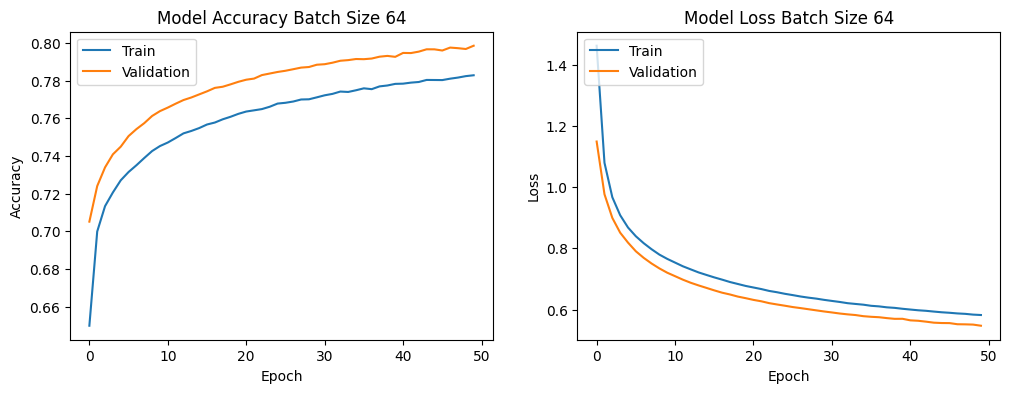

In [21]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy Batch Size 64')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss Batch Size 64')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

**<h1>LOAD MODEL</h1>**

In [22]:
custom_objects = {'TFBertModel': TFBertModel}
loaded_model = load_model('./fix/gru_alone.keras', custom_objects=custom_objects, compile=False)
optimizer = Adam(1e-5)
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 96)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 96)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 96,                                            

**<h1>VALIDATION</h1>**

In [25]:
y_pred_prob = loaded_model.predict(test_tf_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

4395/4395 [==============================] - 860s 195ms/step


In [26]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

In [27]:
conf_matrix = confusion_matrix(y_true, y_pred)

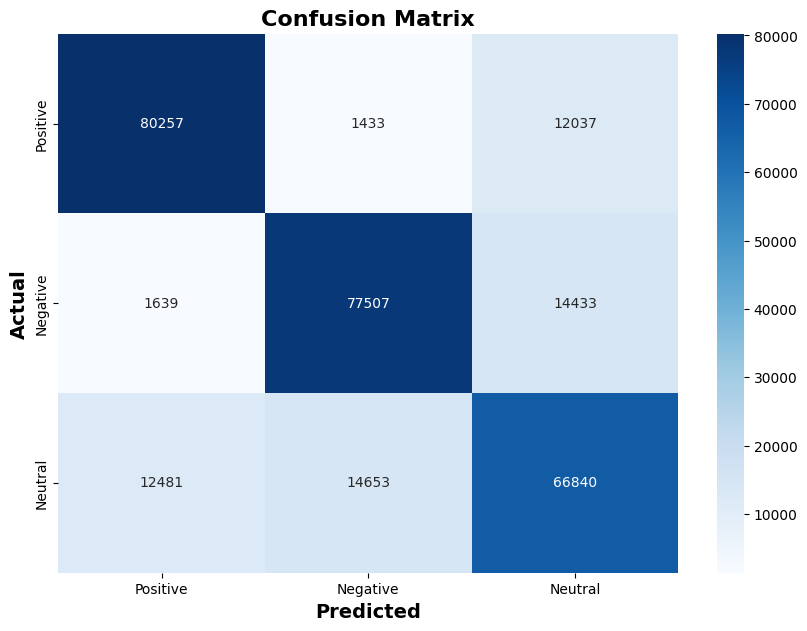

In [28]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [29]:
print(classification_report(y_true, y_pred, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.85      0.86      0.85     93727
    Negative       0.83      0.83      0.83     93579
     Neutral       0.72      0.71      0.71     93974

    accuracy                           0.80    281280
   macro avg       0.80      0.80      0.80    281280
weighted avg       0.80      0.80      0.80    281280

